# Introduction
We were given a project to scrape data from job posting websites, for positions related to data scientists. Based on this data our objective was to predict if the posted job is high paid position or low. Following is a summary of requirements and approach used to tackle.

# Requirements
Following are requirements.

*	Scrape relevant data from job posting websites.
*	Build two models focusing salary trends and job categories.
*	Present a polished Jupyter notebook for explaining approach and code.
*	A write up of 500 to 1000 words.

# Presentation approach
To explain Jupyter notebook we will explain the block of code by formatted HTML documents code wise. Most comments will be part of explanation block so that Python code itself won’t look congested.


# Import modules & URLs assignment
We imported the required modules and as we will get data from web and will process its text features; so our main libraries are web scrapping and NLP. In next block of code we have assigned the basic URL of two famous job boards i.e. Indeed and Seek. These URLs are later appended with paging IDs to scrape data till available number of pages.


In [40]:
"""
Import libraries and set
"""
import numpy as np
import re
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pprint as pprint
import warnings
import requests
from bs4 import BeautifulSoup
from scrapy.selector import Selector
from scrapy.http import HtmlResponse

"""
Modeling Libraries
"""
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer


%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('fivethirtyeight')

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [42]:
"""
URLs assignment for different job portals
""" 
url_indeed = "https://au.indeed.com/jobs?q=data+scientist&l=Australia"
url_seek = "www.seek.com.au/data-scientist-jobs?page="

# Indeed Scrapping Function
When we scrape from web there is lot of text but we need to get only fields what we need. This function will be used to split one job card/one job record into multiple fields by simply using the beautiful soup search mechanism. The find will simply find the tag we specify and if there are multiple tags with same name which usually is the case then we make our search specific by using attribute wihin HTML tag. Detail of search can be seen as following.
*	It's the div tag which we are finding and this represents one record. Storing it in variable divs after find_all
*	When you hover the mouse with inspect functionality the shape of one job  is like card so we named our variable as job_card.
*	Within job card we will get individual element as dictionary named as deets.

To build our model the features we selected and commonly available from websites are:

job_id: This will be ID of job and every website has their own mechanism to store it. We will not use it in our model but it’s good to have if 

company: This is company name who posted the job and it is blank as well in some cases to try catch has been placed.

title: This is job title.

summary: Represents summary which we will use for natural language processing. This is most important feature we will use for building our model.

loc: Location of job and this will provide a distribution of jobs in different cities.

pay: This shows salary and has lot of different formats and will need lot of cleaning. And also it has lot of blank values. It is most important feature in our data frame and in technical terms this is y our target variable. Based on its median value we will classify our next target the actual y as high or low salary value.

Note: As this code will be called for every job so to simplify our solution we have compiled it as a function. Inside For loop we have used only find instead of find_all as we are interested in only first occurrence. The tags search in find is based on inspection (inspect feature of chrome browse) of attributes within browser.

In [43]:
def scrape_indeed_page(page_soup):
    divs = soup.find_all("div", class_ = ["row", "result"]) 
    for job_card in divs: 
        deets = {}
        deets["job_id"] = job_card.get("id")
        try:
            deets["company"] = job_card.find("span", class_ = "company").text.strip("\n").strip()
        except AttributeError:
            deets["company"] = None
        try:
            deets["pay"] = job_card.find("span", class_ = "no-wrap").text
        except AttributeError:
            deets["pay"] = None
        deets["title"] = job_card.a.get("title")
        deets["loc"]= job_card.find("span", class_ ="location").text
        deets["summary"] = job_card.find("span", class_ = "summary").text.strip()

        yield deets

# Scrape Indeed
Based on function defined above we will scrape indeed in code below. The end result of this step will be a data frame on which we will start cleaning. Details can be seen as following. 

We assigned output of scraped data to a Beautiful soup object and named it as soup. Next we are getting number of pages values from last three characters of search result which is searchCount attribute in HTML we have.

We are initializing a blank array with name all_jobs for storing required values.

For every individual job in we are calling scrapping function defined above to extract only what we need and discard rest of soup.


In [44]:
#Get number of pages for records to iterate 
r = requests.get('https://au.indeed.com/jobs?q=data+scientist&l=Australia')
soup = BeautifulSoup(r.text, "lxml")
pages = int(int(soup.find("div", {"id":"searchCount"}).text[-3:])/10)

#Blank array for storing required values.
all_jobs = []

# Calling main outer loop with multiplication of 10 because indeed do it this way.
# Instead of putting page 1,2,3 they put like 10,20,30
for job_listings in range(0,pages*10,10):
    r = requests.get("https://au.indeed.com/jobs?q=data+scientist&l=Australia&start={}"\
                     .format(job_listings))
    soup = BeautifulSoup(r.text, "lxml")
    for i in scrape_indeed_page(soup):
        all_jobs.append(i)

# Make a data frame out of it and call it df_indeed
df_indeed = pd.DataFrame.from_dict(all_jobs)

In [48]:
# See the contents of data frame and have a quick look over it
df_indeed.shape #(484,6) 
df_indeed.head()

,company,job_id,loc,pay,summary,title
0,Robert Walters,pj_fe33ea6ee1dc7473,Sydney NSW,"\n $130,000 - $180,000 a year",Extensive knowledge leveraging Data Science sk...,Data Scientist
1,ignite,pj_c713a69fb7982d45,Sydney NSW,"\n $100,000 - $150,000 a year",Working closely with the Head of Data Analytic...,Data Scientist
2,International Institute of Data & Analytics,p_8bea47ce9c4d9b34,Sydney NSW,None,"In data science and big data analytics, the ID...",Junior Data Analyst/Scientist
3,GetSwift,p_9f130428ab735cd1,Melbourne VIC,None,Data analysis and reporting. Enhancing data co...,Data Scientist
4,IESTEC PTY. LTD,p_0b114068555f1aad,Notting Hill VIC,None,"SQL, Data Exploration tools, data modelling sk...",Internship - Engineering/Data Analysis


# Seek Scrapping Function
Seek scrapping is using the same logic what we have used in Indeed. The only difference is in identifying the tag in which our required field is lying. This was done by using inspect feature of browser. Seek was bit easy and less distractive. The main container for one job is called article that's why we are searching article. 


In [49]:
def scrape_seek_page(page_soup):
    articles = soup.find_all("article")    
    for job_card in articles:
        deets = {}
        deets["job_id"] = job_card.get("data-job-id")
        try:
            deets["company"] = job_card.find("a", {"data-automation":"jobCompany"}).text
        except AttributeError:
            deets["company"] = None
        try:
            deets["pay"] = job_card.find("span",{"data-automation":"jobSalary"}).get("aria-label")
        except AttributeError:
            deets["pay"] = None
        deets["title"] = job_card.get("aria-label")
        deets["loc"]= job_card.find("a",{"data-automation":"jobLocation"}).text
        deets["summary"] = job_card.find("span", {"data-automation":"jobShortDescription"}).text

        yield deets

# Scrape Seek
Based on function defined above we will scrape seek in code below. The logic and flow is same what we have seen in Indeed. The difference is in number of pages which is using direct approach so there is no multiplication factor.
End result from this step will be a data frame.


In [50]:
# Get number of pages for records to iterate 

r = requests.get('https://www.seek.com.au/data-scientist-jobs?page=1')
soup = BeautifulSoup(r.text, "lxml")
pages = int(soup.find("strong",{"data-automation":"totalJobsCount"}).text)/20 
# finding total number of jobs from seek. Seek dispalys 20 jobs per page


all_jobs = []
for seek_page in range(1,pages):
    r = requests.get("https://www.seek.com.au/data-scientist-jobs?page={}".format(seek_page))
    soup = BeautifulSoup(r.text, "lxml")
    for i in scrape_seek_page(soup):
        all_jobs.append(i)
        
df_seek = pd.DataFrame.from_dict(all_jobs)

In [52]:
# See the contents of data frame and have a quick look over it
df_seek.shape #(100,6)
df_seek.head()

,company,job_id,loc,pay,summary,title
0,PRA,35174127,Melbourne,None,Iconic household Australian Brand. Be part of ...,Data Scientist
1,Opus Recruitment Solutions,35165505,Melbourne,Salary: $90000 - $120000 per annum,Gaming\r\nAmazing benefits\r\nCustomer focused...,JUNIOR MID DATA SCIENTIST
2,Robert Walters,35164288,Sydney,Salary: $130k - $180k p.a.,"Machine Learning, Big Data, Cyber Security, Ha...",Data Scientist
3,QBE,35161171,Adelaide,None,As QBE ANZO on embarks building a data driven ...,Data Scientist
4,QBE,35161162,Melbourne,None,As QBE ANZO on embarks building a data driven ...,Data Scientist


# Drop Duplicates
Drop duplicate data from both data frames.


In [290]:
pd.DataFrame.drop_duplicates(df_indeed, inplace = True)
pd.DataFrame.drop_duplicates(df_seek, inplace = True)
df_indeed.shape #(282, 6)
df_seek.shape #(99, 6)

(20, 6)

# Save Data Frame to file (Iteration 1)
Saving data frame to file so that we don’t have to scrap again if something goes wrong with internet connectivity.


In [73]:
# df_indeed.to_csv("df_indeed_file_1",encoding='utf-8') # Witout encoding it was giving an error.
# df_seek.to_csv("df_seek_file_1",encoding='utf-8') # Witout encoding it was giving an error.

# Identify Data Cleaning
We are identifying data cleaning needs and it will be needed in salary mostly as we want this to have only numeric values. Using unique function will tell us what patterns are existing in pay. Indeed data for pay field is quite structured and following patterns can be seen.
* Starting with \n which we need to chop
* 	Categories are ending with "a year" and having a range
* 	Categories are ending with "a year" and NOT having a range
* 	Categories are ending with "a week"
* 	Categories are ending with "a day" and having a range
* 	Categories are ending with "a day" and NOT having a range

Seek data is more messed up but salary start with $ after the string "Salary: " so this can be a good starting point.
Other fields of data frames are quite clean and we will just remove carriage return character out of it.


In [55]:
# Data cleaning identification
df_indeed.pay.unique()
df_seek.pay.unique()

# df_indeed['loc'].unique() #Quite organized and clean
# np.sort(df_indeed['company'].unique()) #Quite organized and clean
# np.sort(df_indeed['title'].unique()) #Quite organized and clean

# df_seek['loc'].unique() #Quite organized and clean
# np.sort(df_seek['company'].unique()) #Quite organized and clean
# np.sort(df_seek['title'].unique()) #Quite organized and clean
# df_indeed.pay.unique()

array([None, 'Salary: $90000 - $120000 per annum',
       'Salary: $130k - $180k p.a.', 'Salary: Negotiable',
       'Salary: 100,000', 'Salary: $450-600 pd /  $100-120k pa',
       'Salary: US$75k - US$200k p.a. + Negotiable',
       'Salary: Great Rems + End User + Parking + Generous Bonuses',
       'Salary: Up to $90000.00 p.a.', 'Salary: $85,000 - $120,000',
       'Salary: 80-120k + Super', 'Salary: $100000 - $200000 per annum',
       'Salary: $450-600 per day', 'Salary: $150000',
       'Salary: Base + 13% Super + Bonuses/Benefits',
       'Salary: $101,944 to $116,053', 'Salary: Competitive',
       'Salary: $110-130k + Super + Bonus',
       'Salary: $120000.00 - $130000.00 p.a.',
       'Salary: $120,000 - $140,000 Package',
       'Salary: $90-$130phr\r\n\r\nAll agent Client fees disclosed',
       'Salary: $75,000 - $79,999',
       'Salary: Uncapped Commission / OTE $100-300k+',
       'Salary: $110,000 - $130,000 + Super + Equity',
       'Salary: competitive',
       'S

# Split & Average Function
Writing function so multiple cleaning, split and average can be called by apply method. This function takes the value with a – in it. Split it into two parts and take average. This average will be return value as numeric.


In [57]:
def split_avg(x):
    x = x.replace(" ","") #Remove spaces
    x = x.split("-")
    x_avg = (float(x[0])+float(x[1]))/2
    return x_avg

# Data Cleaning Actions
Time to take some actions and butcher the data. In sequence of appearing in code the actions are following on Indeed Data Frame:

* Strip off initial part
* 	Strip off year at end
* 	Strip off dollar in second part of range
* 	Strip off comma
* 	Strip off "a d" for "a day"
* 	Strip off "a d" for "an hou"
* 	Strip off "a d" for "a week"
* 	Fixing those values which are equal to 3 or less than 3 in length and assuming them to be per day rate.
* 	Multiplying it with 260 working days per year. 52 Weeks into 5 days = 260
* 	Converting range into average.
* 	Even after that if there are daily salaries converting it into annual.
* 	Drop rows which are less than 50000 per anum salary
* 	Drop rows which are not having salary information

In sequence of appearing in code the actions are following on Seek Data Frame:

* 	Dropping rows without pay information as first step. Lesson learned from Indeed cleaning.
* 	Strip left part of pay field
* 	Find salaries with strings Attractive,Base,Competitive,Great,Negotiable,competitive examined. Drop it.
* 	Strip off dollar signs and commas


In [58]:
# Data cleaning actions on Indeed
df_indeed.loc[df_indeed['pay'].isnull() == False,'pay'] = df_indeed.loc[df_indeed['pay'].isnull() == False,'pay'].str.lstrip("\n                $")
df_indeed.loc[df_indeed['pay'].isnull() == False,'pay'] = df_indeed.loc[df_indeed['pay'].isnull() == False,'pay'].str.rstrip(" a year")
df_indeed.loc[df_indeed['pay'].isnull() == False,'pay'] = df_indeed.loc[df_indeed['pay'].isnull() == False,'pay'].str.replace("$","")
df_indeed.loc[df_indeed['pay'].isnull() == False,'pay'] = df_indeed.loc[df_indeed['pay'].isnull() == False,'pay'].str.replace(",","")

df_indeed.loc[((df_indeed['pay'].isnull()== False)&(df_indeed['pay'].str.contains('a d'))),'pay']\
=\
df_indeed.loc[((df_indeed['pay'].isnull()== False)&(df_indeed['pay'].str.contains('a d'))),'pay']\
.str.rstrip('a d')

df_indeed.loc[((df_indeed['pay'].isnull()== False)&(df_indeed['pay'].str.contains('an hou'))),'pay']\
=\
df_indeed.loc[((df_indeed['pay'].isnull()== False)&(df_indeed['pay'].str.contains('an hou'))),'pay']\
.str.rstrip('an hou')

df_indeed.loc[((df_indeed['pay'].isnull()== False)&(df_indeed['pay'].str.contains('a week'))),'pay']\
=\
df_indeed.loc[((df_indeed['pay'].isnull()== False)&(df_indeed['pay'].str.contains('a week'))),'pay']\
.str.rstrip('a week')

#Converting per day pay without range into annual
df_indeed.loc[\
            (\
            (df_indeed['pay'].isnull() == False)\
            &\
            (df_indeed['pay'].str.contains("-")==False)\
            &\
            (df_indeed['pay'].str.len() <=3)\
            )\
            ,'pay']\
=\
df_indeed.loc[\
            (\
            (df_indeed['pay'].isnull() == False)\
            &\
            (df_indeed['pay'].str.contains("-")==False)\
            &\
            (df_indeed['pay'].str.len() <=3)\
            )\
            ,'pay']\
.astype(int)*260

#Splitting range and taking average.
df_indeed.loc[\
            (\
            (df_indeed['pay'].isnull() == False)\
            &\
            (df_indeed['pay'].str.contains("-")==True)\
            )\
            ,'pay']\
=\
df_indeed.loc[\
            (\
            (df_indeed['pay'].isnull() == False)\
            &\
            (df_indeed['pay'].str.contains("-")==True)\
            )\
            ,'pay']\
.apply(split_avg)

#Dealing outliers with still small anuall salaries but without dash
df_indeed.loc[\
            (\
            (df_indeed['pay'].isnull() == False)\
            &\
            (df_indeed['pay'] < 2000)\
            )\
            ,'pay']\
=\
df_indeed.loc[\
            (\
            (df_indeed['pay'].isnull() == False)\
            &\
            (df_indeed['pay'] < 2000)\
            )\
            ,'pay']\
.astype(int)*260

#Change data type pay column 
df_indeed[['pay']] = df_indeed[['pay']].astype(float)

#Drop any rows which are less than 50000 per anum 
df_indeed.drop (df_indeed.index[df_indeed['pay'] < 50000], inplace=True,axis=0)

# Drop rows which are not having pay/salary information
df_indeed.drop(df_indeed.index[df_indeed['pay'].isnull()==True],inplace=True,axis=0)

In [59]:
# Inspect how cleaning actions performed.
df_indeed.head()

,company,job_id,loc,pay,summary,title
0,Robert Walters,pj_fe33ea6ee1dc7473,Sydney NSW,155000.0,Extensive knowledge leveraging Data Science sk...,Data Scientist
1,ignite,pj_c713a69fb7982d45,Sydney NSW,125000.0,Working closely with the Head of Data Analytic...,Data Scientist
5,eWave,p_61b2b19baaa4c0df,Sydney NSW,200000.0,"Hiring, Mentoring and Leading a team of up and...","Principal Consultant, Artificial Intelligence ..."
6,University of New South Wales,p_c2da0797d42f9b8b,Kensington NSW,95000.0,One of Australia’s leading research & teaching...,Research & Technology Analyst
11,Youth & Programmes Group,p_40a416d5f9ef6a1d,Canberra ACT,77541.0,To complete these investigations we use both t...,"Data Analyst |Data Scientist - Canberra, ACT"


In [65]:
# Data cleaning actions on Seek
df_seek.drop(df_seek.index[df_seek['pay'].isnull() == True],inplace=True,axis=0)
df_seek.loc[df_seek['pay'].isnull() == False,'pay'] = df_seek.loc[df_seek['pay'].isnull() == False,'pay'].str.lstrip("Salary: ")
df_seek.drop(df_seek.index[df_seek['pay'].str.contains('Attractive')],inplace=True,axis=0)
df_seek.drop(df_seek.index[df_seek['pay'].str.contains('Base')],inplace=True,axis=0)
df_seek.drop(df_seek.index[df_seek['pay'].str.contains('Competitive')],inplace=True,axis=0)
df_seek.drop(df_seek.index[df_seek['pay'].str.contains('Great')],inplace=True,axis=0)
df_seek.drop(df_seek.index[df_seek['pay']=='Negotiable'],inplace=True,axis=0)
df_seek.drop(df_seek.index[df_seek['pay']=='competitive'],inplace=True,axis=0)

# Using wise approach to put search items for blank replacement in a list and calling in for loop
replacement_list = ["$",",","+","Super","Equity","FTE","Super","per annum","k","p.a.","Bonus",\
    "Package","p.d.","per day","All agent Client fees disclosed","Negotiable","Benefits",\
    "Pacage","Up to ","super","p.h.","phr","US","pd /", "pa","UncapCommission / OTE","/day GST"]
for items in replacement_list:
    df_seek.loc[df_seek['pay'].isnull() == False,'pay'] = df_seek.loc[df_seek['pay'].isnull() == False,'pay'].str.replace(items,"")

df_seek.loc[df_seek['pay'].isnull() == False,'pay'] = df_seek.loc[df_seek['pay'].isnull() == False,'pay'].str.replace("to","-")
df_seek.loc[df_seek['pay'].isnull() == False,'pay'] = df_seek.loc[df_seek['pay'].isnull() == False,'pay'].str.strip()

In [70]:
"""
Cleaning action continued
"""
# Splitting range and taking average.
df_seek.loc[\
            (\
            (df_seek['pay'].isnull() == False)\
            &\
            (df_seek['pay'].str.contains("-")==True)\
            )\
            ,'pay']\
=\
df_seek.loc[\
            (\
            (df_seek['pay'].isnull() == False)\
            &\
            (df_seek['pay'].str.contains("-")==True)\
            )\
            ,'pay']\
.apply(split_avg)

#Change data type pay column 
df_seek[['pay']] = df_seek[['pay']].astype(float)

#Converting per day pay without range into annual
df_seek.loc[\
            (\
            (df_seek['pay'].isnull() == False)\
            &\
            (df_seek['pay'] <=1000)\
            )\
            ,'pay']\
=\
df_seek.loc[\
            (\
            (df_seek['pay'].isnull() == False)\
            &\
            (df_seek['pay'] <=1000)\
            )\
            ,'pay'].astype(int)*260

#Drop any rows which are less than 50000 per anum 
df_seek.drop (df_seek.index[df_seek['pay'] < 50000], inplace=True,axis=0)

In [72]:
# Inspect how cleaning actions performed.
df_seek.head()
# df_seek.shape
# 500/day  GST
# df_seek.loc[df_seek.pay == '500/day  GST']['pay'] = df_seek.loc[df_seek.pay == '500/day  GST']['pay'].str.rstrip('/day  GST')
# df_seek.drop([92,93],inplace=True)

,company,job_id,loc,pay,summary,title
1,Opus Recruitment Solutions,35165505,Melbourne,105000.0,Gaming\r\nAmazing benefits\r\nCustomer focused...,JUNIOR MID DATA SCIENTIST
8,Genesis IT&T P/L,35150213,Sydney,100000.0,A very exciting opportunity has now become ava...,Data Scientist | Junior to Mid Level
9,Correlate Resources,35154172,Sydney,300275.0,CORRELATE RESOURCES : Your trusted Data Analyt...,Customer Data Scientists / Analytics Consultants
12,Bluefin Resources Pty Limited,35138308,Melbourne,90000.0,Data Science Roles (multiple positions),Data Scientist
15,Ratio Group,35124925,Sydney,102500.0,This is a new breed of role not yet seen in th...,Research Analyst / Data Scientist - Hedge Fund


# Save Data Frame to file (Iteration 2)
Saving data frame to file so that we don’t have to do cleaning again if something goes wrong.


In [82]:
# Writing progress till now in CSV file and saving this as version 2
df_indeed.to_csv("df_indeed_file_2",encoding='utf-8') # Witout encoding it was giving an error.
df_seek.to_csv("df_seek_file_2",encoding='utf-8') # Witout encoding it was giving an error.

# Combine Data frames as df
Combine both data frames so that we can build model on it after all cleaning is done. Make sure that value of pay field is numeric as we will use it for calculation. For simplicity we will also reset index of data frame.


In [81]:
# Combining both data frames and name it as df
df = [df_indeed,df_seek]
df = pd.concat(df)
df[['pay']] = df[['pay']].astype(float)
df.reset_index(inplace=True)
df.head()

,index,company,job_id,loc,pay,summary,title
0,0,Robert Walters,pj_fe33ea6ee1dc7473,Sydney NSW,155000.0,Extensive knowledge leveraging Data Science sk...,Data Scientist
1,1,ignite,pj_c713a69fb7982d45,Sydney NSW,125000.0,Working closely with the Head of Data Analytic...,Data Scientist
2,5,eWave,p_61b2b19baaa4c0df,Sydney NSW,200000.0,"Hiring, Mentoring and Leading a team of up and...","Principal Consultant, Artificial Intelligence ..."
3,6,University of New South Wales,p_c2da0797d42f9b8b,Kensington NSW,95000.0,One of Australia’s leading research & teaching...,Research & Technology Analyst
4,11,Youth & Programmes Group,p_40a416d5f9ef6a1d,Canberra ACT,77541.0,To complete these investigations we use both t...,"Data Analyst |Data Scientist - Canberra, ACT"


# EDA
Let’s do some EDA and see if we can identify some significant values and trends. Though most data is in form of natural language but we can stull extract something based on salary and city fields which was quite clean.

Describe is a great feature and it works even on non numeric data. It tells us following facts.

* Tells us some insights like where most jobs are i.e Sydney NSW, most frequent pay is 99000.
* 	Top occurring words in Summary are "Australia’s financial intelligence". 
* 	Top occurring words in title are "Senior Data Scientist – Enterprise Analytics"


In [82]:
#EDA
df.describe()

# df.pay.mean() # Average salary is 124044.51485148515 per anum
# df.pay.max() # Maximum salary is 300000.0 per anum
# df.pay.min() # Minimum salary is 57500.0
# df.pay.median() # Median is 115000.0

,index,pay
count,103.000000,103.000000
mean,175.504854,121860.912621
std,135.996963,43621.638521
min,0.000000,52000.000000
25%,50.000000,95294.000000
50%,146.000000,110000.000000
75%,287.500000,136500.000000
max,424.000000,300275.000000


# MORE Cleaning
You must have been used to the fact that 80 percent of time data scientists are spending in cleaning so it was not over yet. We are removing carriage return characters if they are existing in fields other than pay/salary.


In [90]:
# Clean carriage return \n character from any field by writing a function.
def clean_cr(x):
    x.str.encode('utf-8').astype(str).str.replace('\n', '')
    return x

In [89]:
# Check fields where we need to apply carriage return character.
# Only summary needs cleaning.
df[df['summary'].str.contains("\n")==True] #2 records
df[df['company'].str.contains("\n")==True] #0 records
df[df['job_id'].str.contains("\n")==True] #0 records
df[df['loc'].str.contains("\n")==True] #0 records
df[df['pay'].isnull()==True] #0 records
df[df['title'].isnull()==True] #0 records

,index,company,job_id,loc,pay,summary,title


In [88]:
# Clean summary column for carriage return character
df['summary'] = df['summary'].str.replace('\n', '')

# Feature Enrichment into City and State
We only had location in web scrapping. To enhance our feature we will split it into city and state and if required will do cleaning of it as well.
In next steps we are checking the data quality of city and state added, and applying the cleaning actions needed for these.


In [90]:
"""
Split location into city and state as feature enriching.
"""
aus_states = ['NSW','VIC','SA','WA','NT','QLD','ACT','TAS']
city_list = []
state_list = []
for loc in (df['loc']):
    if loc[-3:].strip() in aus_states: # Check last three charatcers after trimming
        city = loc[:-3] #start till start start of last three characters
        state = loc[-3:] #last three characters
        city_list.append(city)
        state_list.append(state)
    else:
        city = loc
        state = None
        city_list.append(city)
        state_list.append(state)
df['city'] = city_list
df['state'] = state_list
#     print loc,"#",city,"#",state

In [116]:
"""
Checking data quality of newly added features
"""
df[df['city'].isnull()] # No null city
df[df['state'].isnull()].shape # 29 null states
df[df['state'].isnull()]['city'].unique() # values are Australia,Victoria,Melbourne,Sydney,Adelaide,Brisbane
df.loc[((df['state'].isnull()) & (df['city']=='Australia')),'state'] # 6 records
df.loc[((df['state'].isnull()) & (df['city']=='Victoria')),'state'] # 1 record only
df.loc[((df['state'].isnull()) & (df['city']=='Melbourne')),'state'] # 7 records
df.loc[((df['state'].isnull()) & (df['city']=='Sydney')),'state'] # 12 records
df.loc[((df['state'].isnull()) & (df['city']=='Adelaide')),'state'] # 1 record
df.loc[((df['state'].isnull()) & (df['city']=='Brisbane')),'state'] # 1 record

array([], dtype=object)

In [115]:
"""
Update block 
"""
df.loc[((df['state'].isnull()) & (df['city']=='Australia')),'state'] = 'ACT'
df.loc[((df['state'].isnull()) & (df['city']=='Victoria')),'state'] = 'VIC'
df.loc[((df['state'].isnull()) & (df['city']=='Melbourne')),'state'] = 'VIC'
df.loc[((df['state'].isnull()) & (df['city']=='Sydney')),'state'] ='NSW'
df.loc[((df['state'].isnull()) & (df['city']=='Adelaide')),'state'] ='SA'
df.loc[((df['state'].isnull()) & (df['city']=='Brisbane')),'state'] ='QLD'

In [140]:
"""
Checking data frame after cleaning.
Had to do lot of trimming.
"""
df.city.unique()
# df.state.unique()
# df.loc[df.state=='Melbourne','state'] = 'VIC'
# df.loc[df.state==' SA','state'] = 'SA'
# df.loc[df.city=='Australia'] # Most jobs from CSIRO which is based in ACT sp better change it to Canberra
# df.loc[df.city=='Australia','city'] = 'Canberra '
# for i in np.sort(df.state.unique()):
#     print i
# df.loc[df['state'].isnull() == False,'state']  = df.loc[df['state'].isnull() == False,'state'].str.strip()
# df.loc[df['city'].isnull() == False,'city']  = df.loc[df['city'].isnull() == False,'city'].str.strip()
# df.loc[df['city'] == 'Victoria','city'] = df.loc[df['city'] == 'Victoria','city'].str.replace('Victoria','Melbourne')
# df.loc[df['city'].isnull() == True]

,company,job_id,loc,pay,summary,title,city,state


# Feature Enrichment as High Pay
We have decided that we will build our model based on classification if the salary is low or high. For this we will classify the salary based on its median value. On this criteria a new feature will be added to data frame.
We have also checked that what is distribution of high and low. This will help us in modeling based on tree/random forest.


In [91]:
"""
Adding classifier of high_pay to be a binary variable and this will be our target variable in modeling
"""
median_pay = np.median(df.pay)
median_pay # 110000.0

110000.0

In [92]:
df['high_pay'] = [1 if i > median_pay else 0 for i in df.pay]

In [93]:
df.high_pay.value_counts() # Almost equal counts 53 low pays and 50 high pays

0    53
1    50
Name: high_pay, dtype: int64

In [147]:
"""
Writing it to CSV file which should be pretty clean. After checking that there are no null values.
"""
df.shape
df[df['state'].isnull()]
df.to_csv("df.csv",encoding='utf-8') 

In [105]:
"""
Did a bit of cleaning in excel and making data frame out of it.
"""
df = pd.read_csv("df_20171228_2232.csv")

In [109]:
df.head()

,company,job_id,loc,pay,summary,title,city,state,high_pay
0,eWave,p_61b2b19baaa4c0df,Sydney NSW,200000.0,"Hiring, Mentoring and Leading a team of up and...","Principal Consultant, Artificial Intelligence ...",Sydney,NSW,1
1,University of New South Wales,p_8d38c21ddc704129,Kensington NSW,108500.0,The software developer / FPGA programmer will ...,Quantum computing software developer / FPGA pr...,Kensington,NSW,0
2,University of Melbourne,p_5c54cb16d9c8314b,Parkville VIC,81489.0,However little is known about how well state-o...,RESEARCH FELLOW IN ADVERSARIAL MACHINE LEARNING,Parkville,VIC,0
3,University of Melbourne,p_120370ad9fc36fe4,Parkville VIC,81489.0,The research fellow will join a team of academ...,RESEARCH FELLOW IN MACHINE LEARNING FOR ENGINE...,Parkville,VIC,0
4,Big Wednesday Digital,p_91c83431cbe7e81e,Australia,300000.0,At least 5-10 years working as a statistician ...,Head Of Data,Canberra,ACT,1


# Modeling on Data frame (City)
As we are done with data cleaning so we will start making model out of it. Following is an overview of it. We will start with very simple approach and will model based on city field only. As city is string value and apparently it does not seem to be a predictor so we will convert city into features by using dummies method of pandas. Now as the cities are itself columns/features so we can use these numeric values for modeling. We will use mathematical terms X for input and y as output. The use of generic mathematical terms will allow us to reuse the code and make it easily understandable for audience.

To test our model we will use the function train and test split. We will use 70 percent data for training and 30 percent for testing of it.

We are choosing random forest for our classification. The reason to choose this model is that it is suitable when target is balanced and in our case we have already seen that. Our low and high salaries are almost equally distributed.


In [292]:
# CITY based Modeling
city_dummies = pd.get_dummies(df.city)
city_dummies.shape # (96, 17), 17 were unique cities and they were transformed as columns

X = city_dummies
y = df.high_pay

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=6)

In [293]:
# Fitting X and y data into model called as rfc Random Forest Classfier and checking accuracy.

rfc = RandomForestClassifier(n_estimators=18, random_state=6)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
acc = accuracy_score(y_test, rfc_pred)
print "Accuracy Score:", acc.round(3)

s = cross_val_score(rfc, X, y, cv=6, n_jobs=-1)
print "Cross Validation Score:\t{:0.3} ± {:0.3}".format(s.mean().round(3), s.std().round(3))

Accuracy Score: 0.724
Cross Validation Score:	0.706 ± 0.1


# Results of Modeling on Data frame (City)
We tried different parameters on n_estimators parameters which identifies number of trees. The optimum score was at 18. Following was score and cross validation score.

Accuracy Score: 0.724

Cross Validation Score:	0.706 ± 0.1

We tried to implement the same on “State” feature but score was not that much optimum. It was just 0.69.


# Individual importance of feature (City)
Following code will show how much a city as feature was important in predicting the salary classification. First statement just takes feature name and scores. Second step is giving name to 2 features of data frame available till now. Third step of for loop is filling the median value for pay from main data frame for particular city (feature). Forth step just compares it with median_pay we already calculated from main frame above.


In [301]:
# Feature importance CITY
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X.columns).reset_index()
feature_importances.columns = ['feature', 'importance']
feature_medians = []

for i in X.columns:
    feature_medians.append(np.median(df[df.city == i].pay))
feature_importances['median_pay'] = feature_medians
feature_importances['high_pay'] = [1 if i > median_pay else 0 for i in feature_importances.median_pay]

feature_importances.sort_values('importance', ascending=False)

,feature,importance,median_pay,high_pay
15,Sydney,0.357759,120000.0,1
12,Parkville,0.114889,81489.0,0
2,Canberra,0.105181,123250.0,1
8,Melbourne,0.095414,105000.0,0
0,Adelaide,0.081141,94135.0,0
1,Brisbane,0.059772,193750.0,1
5,Hobart,0.033943,147000.0,1
11,Paddington,0.028982,85500.0,0
6,Kensington,0.027443,101750.0,0
13,Perth,0.025891,93000.0,0


# Modeling using NLP (Summary)
While modeling based on city we used get dummies as it was not a large data set for cities.  But this approach will not be that much useful for summary field which has lot of natural language words.  Here we will use libraries from Python NLP and the count vectorizer function denoted as cv.

Check number of features we can see that there are 569 different columns after removal of stop words.


In [143]:
# SUMMARY based modeling using NLP
X = df.summary
y = df.high_pay
cv = CountVectorizer(stop_words="english",ngram_range=(1, 1),min_df=1)
cv.fit(X)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [144]:
len(cv.get_feature_names()) # 569 features/words after excluding stop words

569

In [152]:
# Fitting X and y data into model called as rfc Random Forest Classfier and checking accuracy.

X_trans = pd.DataFrame(cv.transform(X).todense(), columns=cv.get_feature_names())
X_train, X_test, y_train, y_test = train_test_split(np.asmatrix(X_trans), y, test_size=0.2,
                                                    random_state=60, stratify=y)

rfc = RandomForestClassifier(150, random_state=6)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
acc = accuracy_score(y_test, rfc_pred)

print "Accuracy Score:", acc.round(3)
s = cross_val_score(rfc, X_trans.as_matrix(), y.as_matrix(), cv=10, n_jobs=-1)
print "Cross Validation Score: {:0.3} ± {:0.3}".format(s.mean().round(3), s.std().round(3))

Accuracy Score: 0.75
Cross Validation Score: 0.743 ± 0.162


# Results of Modeling on Data frame (Summary)
We tried different parameters on n_estimators parameters which identifies number of trees. The optimum score was at 150. Following was accuracy and cross validation score.

Accuracy Score: 0.75

Cross Validation Score: 0.743 ± 0.162


# Individual importance of feature (Summary)
We are using same code what we have already used and will show which words from summary are important for predicting the classification.


In [153]:
# Feature importance SUMMARY
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_trans.columns).reset_index()
feature_importances.columns = ['feature', 'importance']
feature_medians = []
feature_means = []
for i in X_trans.columns:
    feature_medians.append(np.median(df[df.summary.str.lower().str.contains(i)].pay))
    feature_means.append(np.mean(df[df.summary.str.lower().str.contains(i)].pay))

feature_importances['median_pay'] = feature_medians
feature_importances['mean_pay'] = feature_means
feature_importances['high_pay'] = [1 if i > median_pay else 0 for i in feature_importances.median_pay]

feature_importances.sort_values('importance', ascending=False).head(30)

,feature,importance,median_pay,mean_pay,high_pay
198,experience,0.026539,108500.00,111834.447368,0
140,data,0.018465,116750.00,125082.054878,1
463,scientists,0.016546,135000.00,146565.369565,1
19,agency,0.016105,108998.50,103443.666667,0
472,senior,0.015704,108998.50,112812.187500,0
100,closely,0.014268,193750.00,175166.666667,1
278,involve,0.013479,136500.00,132485.714286,1
452,role,0.012871,102500.00,112121.600000,0
441,research,0.012398,99000.00,98548.900000,0
79,build,0.011869,120000.00,117500.000000,1


# Modeling using NLP (Title)
Same sequence what we did in Summary. But it seems that with 80 percent of training it performs better than summary. Following was accuracy and cross validation score.

Accuracy Score: 0.8

Cross Validation Score: 0.731 ± 0.1

Not much is extracted from company field and accuracy score is in range of .74.

In [154]:
# TITLE based modeling using NLP
X = df.title
y = df.high_pay
cv = CountVectorizer(stop_words="english")
cv.fit(X)
len(cv.get_feature_names()) # 161 features/words after excluding stop words

171

In [161]:
# Fitting X and y data into model called as rfc Random Forest Classfier and checking accuracy.
X_trans = pd.DataFrame(cv.transform(X).todense(), columns=cv.get_feature_names())
X_train, X_test, y_train, y_test = train_test_split(np.asmatrix(X_trans), y, test_size=0.2,
                                                    random_state=59, stratify=y)
rfc = RandomForestClassifier(60, random_state=6)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
acc = accuracy_score(y_test, rfc_pred)

print "Accuracy Score:", acc.round(3)
s = cross_val_score(rfc, X_trans.as_matrix(), y.as_matrix(), cv=10, n_jobs=-1)
print "Cross Validation Score: {:0.3} ± {:0.3}".format(s.mean().round(3), s.std().round(3))

Accuracy Score: 0.8
Cross Validation Score: 0.731 ± 0.1


In [162]:
# Feature importance TITLE
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_trans.columns).reset_index()
feature_importances.columns = ['feature', 'importance']
feature_medians = []
feature_means = []
for i in X_trans.columns:
    feature_medians.append(np.median(df[df.summary.str.lower().str.contains(i)].pay))
    feature_means.append(np.mean(df[df.summary.str.lower().str.contains(i)].pay))

feature_importances['median_pay'] = feature_medians
feature_importances['mean_pay'] = feature_means
feature_importances['high_pay'] = [1 if i > median_pay else 0 for i in feature_importances.median_pay]

feature_importances.sort_values('importance', ascending=False).head(30)

D:\Anaconda2\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,feature,importance,median_pay,mean_pay,high_pay
132,research,0.079375,99000.0,98548.900000,0
40,data,0.039109,116750.0,125082.054878,1
140,senior,0.038485,108998.5,112812.187500,0
138,scientist,0.033522,120000.0,133961.545455,1
50,engineer,0.032813,120000.0,129541.666667,1
6,analyst,0.030531,120000.0,125031.785714,1
58,fellow,0.028855,81489.0,81489.000000,0
44,developer,0.020760,99250.0,122125.000000,0
38,customer,0.019609,143000.0,143000.000000,1
99,mid,0.019006,105000.0,106250.000000,0


# Modeling using NLP (Company)
Same sequence what we did in Summary. But it seems that company is not that much strong indicator when we compare with summary. Following was accuracy and cross validation score.

Accuracy Score: 0.7

Cross Validation Score: 0.687 ± 0.069

Not much is extracted from company field and accuracy score is in range of .74.

In [163]:
# COMPANY based modeling using NLP
X = df.company
y = df.high_pay
cv = CountVectorizer(stop_words="english")
cv.fit(X)
len(cv.get_feature_names()) # 84 features/words after excluding stop words

84

In [165]:
# Fitting X and y data into model called as rfc Random Forest Classfier and checking accuracy.

X_trans = pd.DataFrame(cv.transform(X).todense(), columns=cv.get_feature_names())
X_train, X_test, y_train, y_test = train_test_split(np.asmatrix(X_trans), y, test_size=0.2,
                                                    random_state=6, stratify=y)

rfc = RandomForestClassifier(60, random_state=6)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
acc = accuracy_score(y_test, rfc_pred)

print "Accuracy Score:", acc.round(3)
s = cross_val_score(rfc, X_trans.as_matrix(), y.as_matrix(), cv=10, n_jobs=-1)
print "Cross Validation Score: {:0.3} ± {:0.3}".format(s.mean().round(3), s.std().round(3))

Accuracy Score: 0.7
Cross Validation Score: 0.687 ± 0.069


In [167]:
# Feature importance COMPANY

feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_trans.columns).reset_index()
feature_importances.columns = ['feature', 'importance']
feature_medians = []
feature_means = []
for i in X_trans.columns:
    feature_medians.append(np.median(df[df.summary.str.lower().str.contains(i)].pay))
    feature_means.append(np.mean(df[df.summary.str.lower().str.contains(i)].pay))

feature_importances['median_pay'] = feature_medians
feature_importances['mean_pay'] = feature_means
feature_importances['high_pay'] = [1 if i > median_pay else 0 for i in feature_importances.median_pay]

feature_importances.sort_values('importance', ascending=False).head(30)

,feature,importance,median_pay,mean_pay,high_pay
66,resources,0.056067,143000.0,143000.000000,1
11,ccinternational,0.049838,NaN,NaN,0
80,university,0.045991,91590.0,91590.000000,0
17,correlate,0.042680,143000.0,143000.000000,1
27,fulsearch,0.042145,NaN,NaN,0
62,recruitment,0.041728,143000.0,143000.000000,1
32,hudson,0.040167,NaN,NaN,0
74,sustainability,0.039757,NaN,NaN,0
71,solutions,0.036948,115000.0,115000.000000,1
18,csiro,0.028107,118500.0,111500.000000,1


# Modeling on Hybrid (All features combined)
We have modelled for salary trends/classification based on individual features of data frame i.e. city, summary and title. What if we combine all of them. The modeling code will remain same as above but the only difference from previous is the concatenation of city, summary and title feature of data frame. We will call this concatenated frame as X.

As company was not a very string predictor so we are not including it in our hybrid model.

We are also checking before putting into model that all elements have same shape for rows.


In [168]:
# HYBRID MODELING
X_city = city_dummies.reset_index() # city_dummies is already defined

X_summ = df.summary
cv.fit(X_summ)
X_summ_trans = pd.DataFrame(cv.transform(X_summ).todense(), columns=cv.get_feature_names())

X_title = df.title
cv.fit(X_title)
X_title_trans = pd.DataFrame(cv.transform(X_title).todense(), columns=cv.get_feature_names())

X = pd.concat([X_city,X_summ_trans,X_title_trans],axis=1)
y = df['high_pay']

print X_city.shape,X_summ_trans.shape,X_title_trans.shape,X.shape,y.shape

(96, 18) (96, 569) (96, 171) (96, 758) (96L,)


In [175]:
X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y, test_size=0.2, random_state=6, stratify=y)

In [181]:
rfc = RandomForestClassifier(300, random_state=6)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
acc = accuracy_score(y_test, rfc_pred)
print "Accuracy Score:", acc.round(3)

s = cross_val_score(rfc, X.as_matrix(), y.as_matrix(), cv=10, n_jobs=-1)
print "Cross Validation Score: {:0.3} ± {:0.3}".format(s.mean().round(3), s.std().round(3))

Accuracy Score: 0.85
Cross Validation Score: 0.833 ± 0.097


# Results of Modeling on Hybrid Data frame 
We tried different parameters on n_estimators parameters which identifies number of trees. The optimum score was at 300. Following was accuracy and cross validation score. Its huge jump from score

Accuracy Score: 0.85

Cross Validation Score: 0.833 ± 0.097


# Individual importance of Hybrid features
We are using same code what we have already used and will show which words from all features combined are important for predicting the classification.


In [182]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_medians = []
for i in X_city.columns:
    feature_medians.append(np.median(df[df.city == i].pay))
for i in X_title_trans.columns:
    feature_medians.append(np.median(df[df.title.str.lower().str.contains(i)].pay))
for i in X_summ_trans.columns:
    feature_medians.append(np.median(df[df.summary.str.lower().str.contains(i)].pay))

feature_importances['median_pay'] = feature_medians
feature_importances['high_pay'] = [1 if i > median_pay else 0 for i in feature_importances.median_pay]

feature_importances.sort_values('importance', ascending=False).head(20)

,feature,importance,median_pay,high_pay
0,index,0.044949,NaN,0
16,Sydney,0.037525,120000.00,1
37,agency,0.017316,118500.00,1
719,research,0.017140,87520.50,0
158,data,0.014473,132500.00,1
727,senior,0.011762,105000.00,0
594,analytics,0.010052,99250.00,0
118,closely,0.009820,114999.50,1
631,developer,0.009818,99000.00,0
481,scientists,0.009762,77541.00,0


# Visualization by heat map (City, Title, Summary)
We are using some basic visualization to see how features are interrelated if we take it for cities and titles of job. Following relations can be seen by cities heat map.
* Observations from heat map of CITIES
* 	Sydney and high_pay
* 	Brisbane and high_pay
* 	Canberra and high_pay
* 	Sydney Central Business District nad high_pay
* 	Sydney and Canberra
* 	Sydney and Melbourne


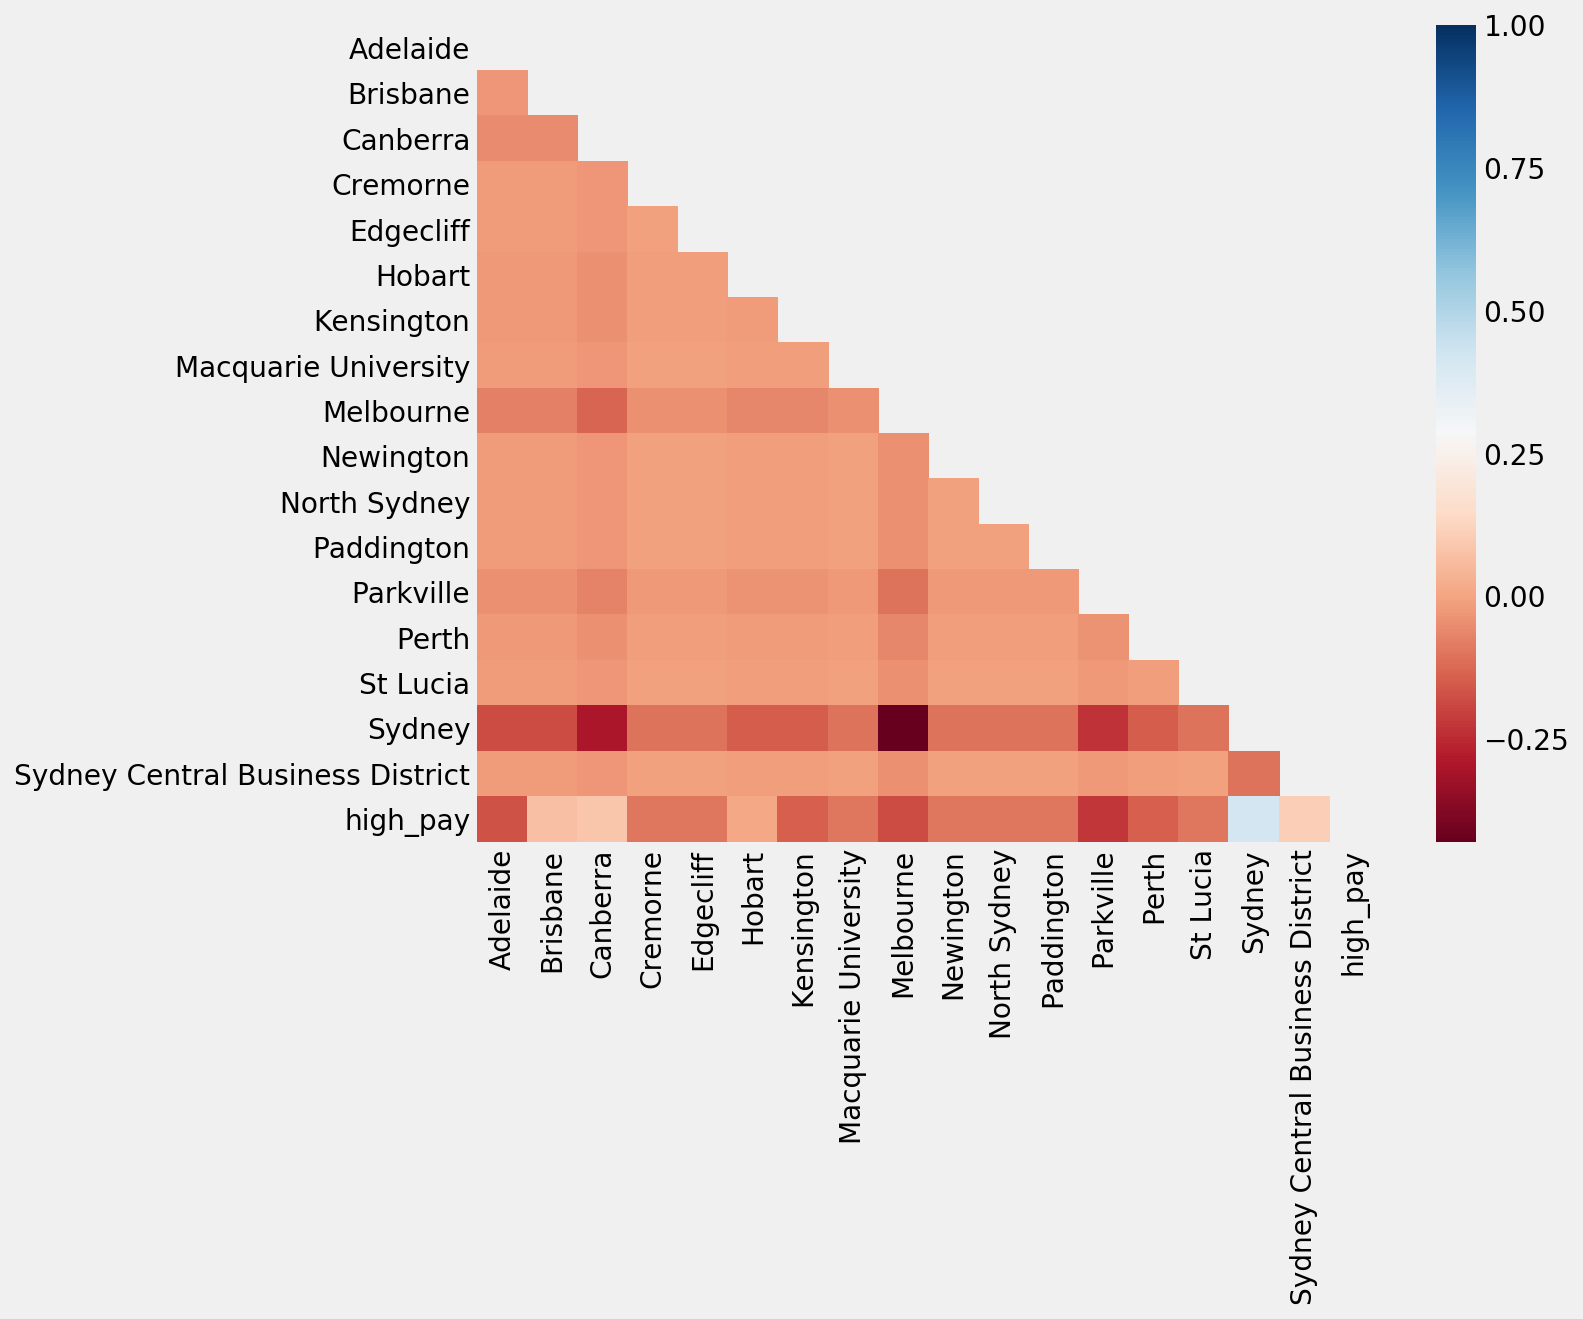

In [185]:
# Heat map of CITIES
dfk_city = df #dfk is another data frame for experimenting KNN algorithm
dfk_city = pd.concat([pd.get_dummies(dfk_city.city),dfk_city.high_pay],axis =1)

mean_corr = dfk_city.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(9,7))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(mean_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(mean_corr, mask=mask, ax=ax,cmap='RdBu')

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14,rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

For visualizing heat map of title and summary we are using an INTELLIGENT feature selection. We are taking only those features which are top scorers when modeling was done. Following relations can be seen by titles heat map.

* enterprise and analytics
* 	scientist and data
* 	scientist and enterprise
* 	scientist and analytics
* 	analytics and senior
* 	enterprise and senior
* 	enterprise and data

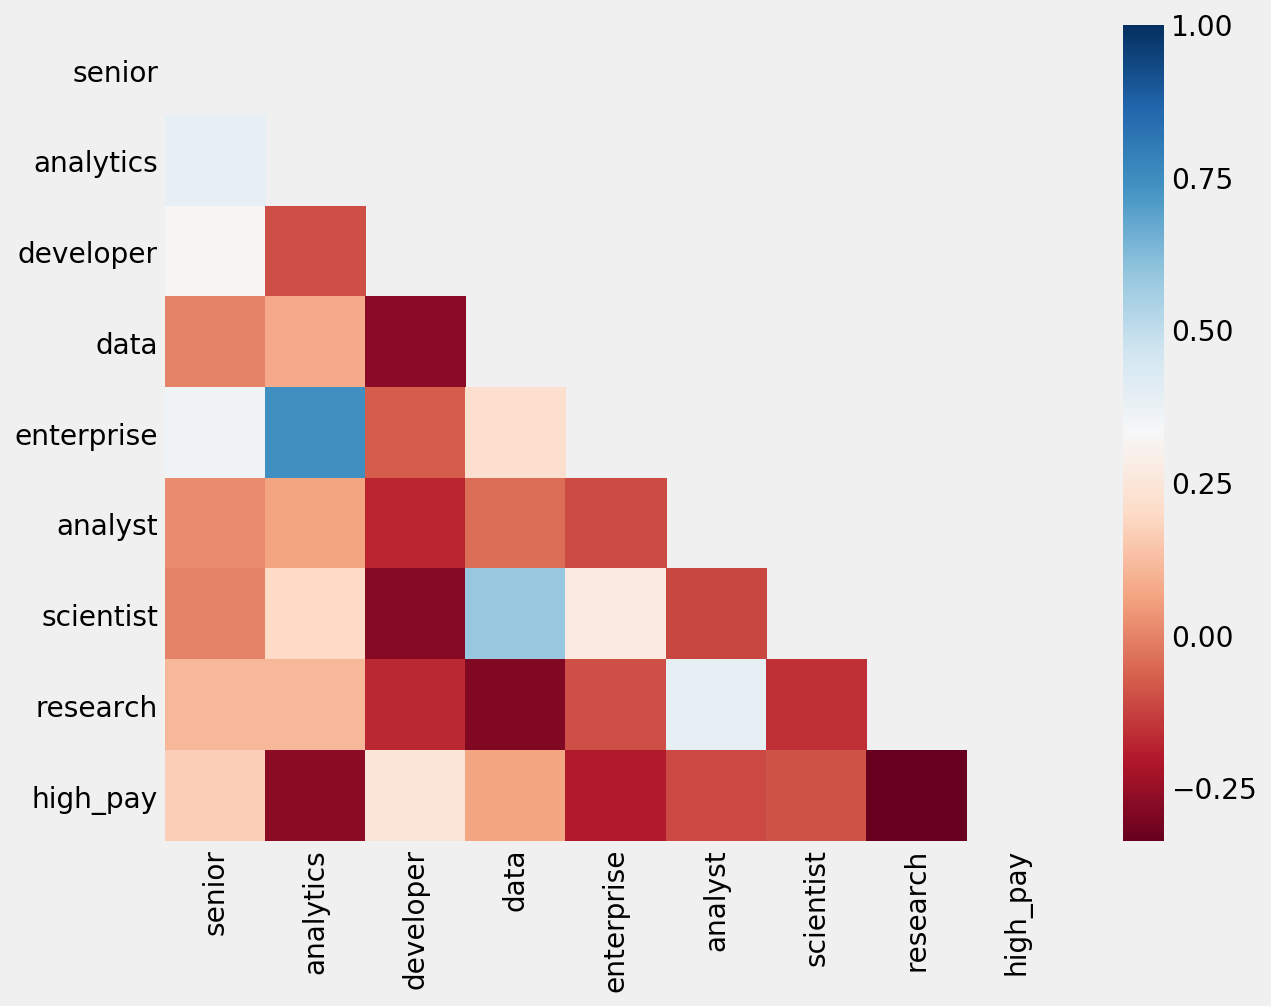

In [194]:
# Heat map of TITLES

dfk_title = pd.concat([X_trans[['senior','analytics','developer','data','enterprise','analyst','scientist','research']],dfk_title.high_pay],axis =1)
inputs = [x for x in dfk_title if x not in ['high_pay']]

mean_corr = dfk_title.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(9,7))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(mean_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(mean_corr, mask=mask, ax=ax,cmap='RdBu')

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14,rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14,rotation=360)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

For visualizing heat map of title and summary we are using an INTELLIGENT feature selection. We are taking only those features which are top scorers when modeling was done. Following relations can be seen by summary heat map.

* high_pay and scientists
* 	high_pay and data
* 	high_pay and senior
* 	largest and data
* 	scientists and data
* 	data and experience
* 	senior and agency

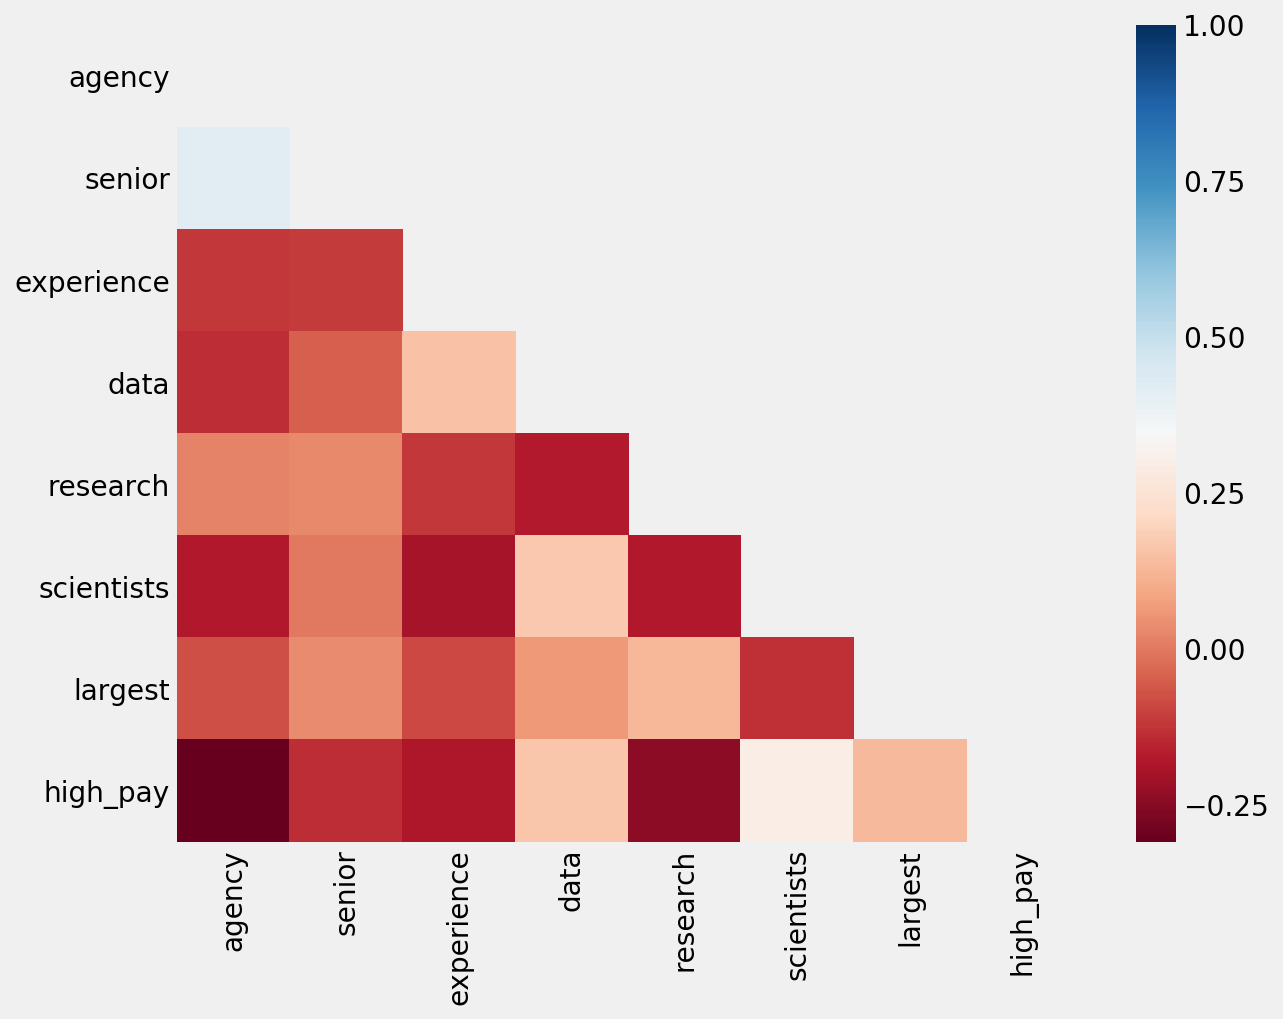

In [200]:
# Heat map of SUMMARY

mean_corr = dfk_summ.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(9,7))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(mean_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(mean_corr, mask=mask, ax=ax,cmap='RdBu')

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14,rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14,rotation=360)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

# City wise job distribution
See which city has high and low paid number of jobs.

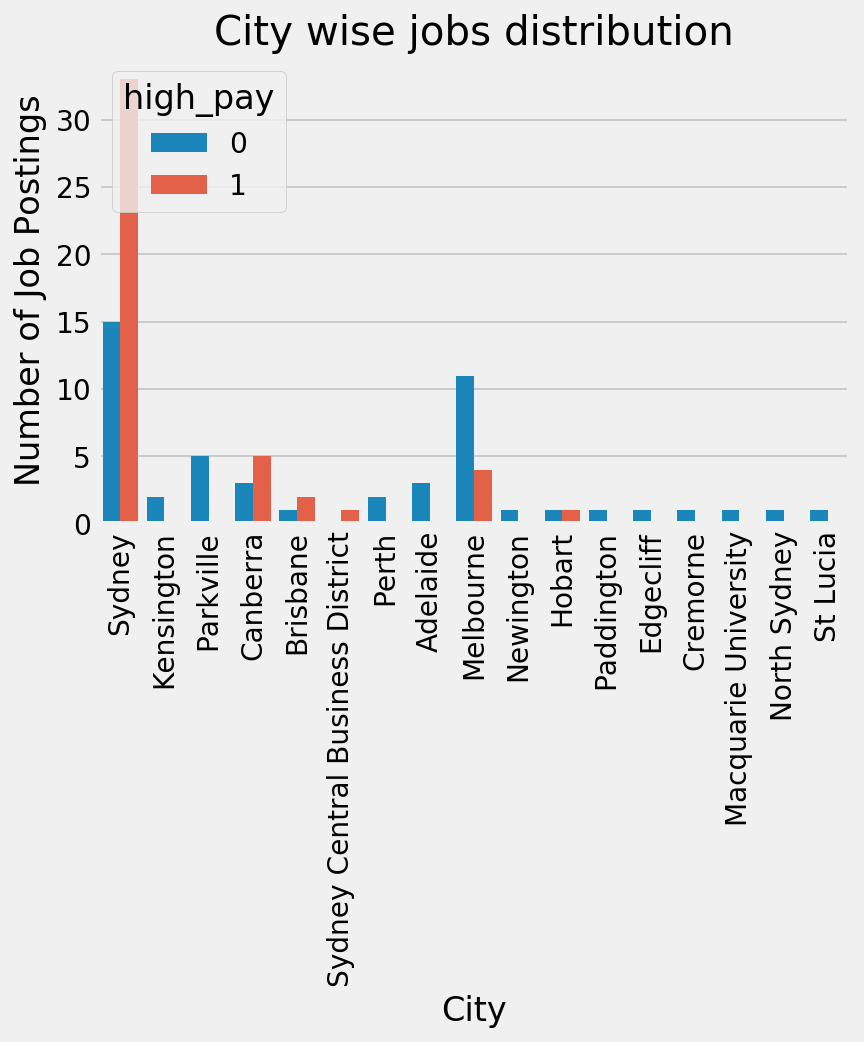

In [278]:
plt.clf()
sns.countplot(x="city", hue="high_pay", data=df)
plt.ylabel("Number of Job Postings")
plt.xlabel("City")
plt.title("City wise jobs distribution")
plt.xticks(rotation=90)
plt.figure(figsize=(20,8))
plt.show()

# K-Means for job categories
We will use k-means as second model for job categories. Target will be to form a k cloud of words which are occurring together. We are using the k = 5 which means that in total there will be 5 classes for words.


In [206]:
vectorizer = TfidfVectorizer(stop_words='english',use_idf=True)
model = vectorizer.fit_transform(df['summary'].str.upper())
km = KMeans(n_clusters=5,init='k-means++',max_iter=300,n_init=1)

k=km.fit(model)
terms = vectorizer.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:,::-1]

for i in range(5):
    print("Cluster of words %d:" %i)
    for ind in order_centroids[i,:10]:
        print(' %s' % terms[ind])
    print "####################################"

Cluster of words 0:
 data
 work
 role
 large
 management
 quality
 use
 production
 literature
 publications
####################################
Cluster of words 1:
 data
 scientists
 working
 science
 closely
 bi
 highly
 understanding
 warehouses
 structure
####################################
Cluster of words 2:
 ai
 product
 data
 opportunity
 team
 learning
 engineers
 involved
 deep
 python
####################################
Cluster of words 3:
 ability
 analyse
 demonstrated
 data
 ongoing
 interpret
 opportunities
 time
 market
 leading
####################################
Cluster of words 4:
 scientist
 australia
 data
 largest
 innovation
 data61
 group
 csiro
 experienced
 join
####################################


# Summary write up
 Our objective was to classify data science related jobs as high paid or otherwise based on extracted data from job board websites. We kept our scope limited to Australian jobs only so two most popular search engines were used for web scraping i.e. Indeed and Seek. The high level plan was to scrap data from web, extract the information of interest, apply cleansing (which took most of time), do feature engineering, apply modeling and summarizing the results.

For web scrapping we tried to use xpath but it was not working when called within Python code so we decided to use beautiful soup, which provides a good feature of finding required tags and attributes. This helped us in extracting fields which were required for building data frame. Scrapping Indeed was more time taking due to complex document structure but scrapping Seek was relatively easy. But when it came to data cleaning stage then Indeed was following a more structured approach for text storage than Seek.

Data cleaning took most of time and it was done separately for both websites before combining. The challenges were different salary formats, missing salary, salary ranges, salary frequencies, invalid city or state names. Though we extracted more than thousand jobs but after cleaning we were left with just ten percent of it on which we could build the model.

For feature engineering we classified our salary as high or low based on its comparison with median value. To have a better visibility based on location we divided it into city and state. This also helped us in identifying jobs distribution. 

For model building we started with simple approach and in start it seemed difficult that how we can build model based on data in which we don’t have any numeric value other than salary. But imagination is more important than numbers (I just modified Einstein’s quote  ). We used cities as first step to see if it can help in predicting high or low salary and it given use good start of 70 percent accuracy. The idea is to make the city value as feature of data frame and assign binary value to it. This binary value indicates presence or absence of feature in a particular record. 

When dealing with jobs related data the most relevant information is present in summary or description of job which is all natural language. The same idea what we used on cities was applied on summary field but we used natural language processing (NLP) libraries for it.

Two models were used and they are; random forest and k-means. We used random forest for classification of high and low salary and got 75 percent accuracy and score. Just scoring was not enough and we also needed to see that what features were contributing in prediction and to how much extent. For this random forest provides feature names and relevant scoring.  Random forest is good to use when we have large number of features and target is classification. 

With k-means model  we have targeted to find cluster of data/words which are closely  related. This can give us a word cloud/map for skills which are advertised in those jobs.


# Tradeoff discussion for high vs low (Bonus question)
Though we have built models which got scoring and accuracy of 85 percent range but still there is ambiguity if all jobs will be classified as high or low accurately. We are doing analysis based on natural language processing and the word which is predicting a job as high salary can also be part of low paid job; and vice versa. But the plus point is that we don’t need to go to individual websites and search results for extracting trends and patterns. Enormous amount of text is processed within matter of minutes.
The significant words based on feature score from random forest are following:

High Salary predictors
* Sydney
* 	Data
* 	Senior
* 	Role
* 	Scientist
* 	BI

Low Salary Predictors

* 	Analytics
* 	Developer
* 	Research
* 	Junior
* 	Reporting
* 	Leads


# The Lab, The Workshop, The Butchery
This is where I tested the code

In [ ]:
"""
Test Lab code
"""
# for seek_page in range(1,9):
#     print("https://www.seek.com.au/data-scientist-jobs?page={}".format(seek_page))

#     r = requests.get("https://www.seek.com.au/data-scientist-jobs?page=1")
# soup = BeautifulSoup(r.text, "lxml")
# divs = soup.find_all("article")
# for i in divs:
    #print(i.prettify())
#     print("-----------------------------------------------------------------")
#     print(i.get("aria-label"))
#     print(i.get("data-job-id"))
#     print(i.find("a", {"data-automation":"jobCompany"}).text)
#     try:
#         print(i.find("span",{"data-automation":"jobSalary"}).get("aria-label")).strip("Salary: ")
#     except AttributeError:
#         print("Hello")
#     print i.find("a",{"data-automation":"jobLocation"}).text
#     print (i.find("span", {"data-automation":"jobShortDescription"}).text)
    
    #deets["loc"]= job_card.find("span", class_ ="location").text
# a = "\n                $100,000 - $150,000 a year"
# a= a.lstrip("\n                $")
# a = a.rstrip(" a year")
# # a = a[20:]
# a = a.replace("$","")
# a = a.replace(",","")
# a
# a[-7:-1]
# df_indeed[['pay']][df_indeed['pay'].isnull() == False]

# x = requests.get("https://www.seek.com.au/data-scientist-jobs?page=1")
# x = BeautifulSoup(x.text)
# int(x.find("strong",{"data-automation":"totalJobsCount"}).text) # finding total number of jobs from seek
# for seek_page in range(1,20):
#     r = requests.get("https://www.seek.com.au/data-scientist-jobs?page={}".format(seek_page))
#     print r.url
# for a in np.sort(df_indeed.pay.unique()):
#     print a
#     print "__"

# df_indeed.loc[((df_indeed['pay'].isnull()== False)&(df_indeed['pay'].str.contains('a d'))),'pay']\
# =\
# df_indeed.loc[((df_indeed['pay'].isnull()== False)&(df_indeed['pay'].str.contains('a d'))),'pay']\
# .str.rstrip('a d')
# df_indeed.loc[\
#             (\
#             (df_indeed['pay'].isnull() == False)\
#             &\
#             (df_indeed['pay'].str.contains("-")==False)\
#             &\
#             (df_indeed['pay'].str.len() <=3)\
#             )\
#             ,'pay']\
# =\
# df_indeed.loc[\
#             (\
#             (df_indeed['pay'].isnull() == False)\
#             &\
#             (df_indeed['pay'].str.contains("-")==False)\
#             &\
#             (df_indeed['pay'].str.len() <=3)\
#             )\
#             ,'pay']\
# .astype(int)*260

# a = '200000 - 250000'
# a= a.replace(" ","") #Remove spaces
# a = a.split("-")
# b = (float(a[0])+float(a[1]))/2
# b


# split_avg('200000 - 250000')

# df_indeed.loc[\
#             (\
#             (df_indeed['pay'].isnull() == False)\
#             &\
#             (df_indeed['pay'].str.contains("-")==True)\
#             )\
#             ,'pay']\
# =\
# df_indeed.loc[\
#             (\
#             (df_indeed['pay'].isnull() == False)\
#             &\
#             (df_indeed['pay'].str.contains("-")==True)\
#             )\
#             ,'pay']\
# .apply(split_avg)

#Dealing outliers with still small anuall salaries but without dash
# df_indeed.loc[\
#             (\
#             (df_indeed['pay'].isnull() == False)\
#             &\
#             (df_indeed['pay'] < 2000)\
#             )\
#             ,'pay']\
# =\
# df_indeed.loc[\
#             (\
#             (df_indeed['pay'].isnull() == False)\
#             &\
#             (df_indeed['pay'] < 2000)\
#             )\
#             ,'pay']\
# .astype(int)*260

#Drop any rows which are less than 50000 per anum 
# df_indeed.drop (df_indeed.index[df_indeed['pay'] < 50000], inplace=True)

# Drop rows which are not having pay/salary information
# df_indeed.drop(df_indeed.index[df_indeed['pay'].isnull()==True],inplace=True,axis=0)

# set the seaborn style to have a white background
sns.set(style="ticks", color_codes=True)

# This function does a pairplot across your variables with the color
# set as the outcome "malignant" class variable
def bcw_pairplotter(df, variables, sample_frac=0.6):
    # sample_frac lets you specify an amount of the data to sample for the plot.
    # this speeds up the function which can take awhile with the full data.
    
    # get the number of rows/data points:
    rows = df.shape[0]
    
    # get downsample indicies for the data, if specified
    if sample_frac < 1.0:
        sample_inds = np.random.choice(range(0,rows), 
                                       size=int(round(rows*sample_frac)), 
                                       replace=False).astype(int)
    
    # make the pairplot for the variables:
    pairs = sns.pairplot(df.iloc[sample_inds, :], 
                         vars=variables, 
                         hue="high_pay", 
                         palette=sns.xkcd_palette(['windows blue', 'amber']))

# X_test = pd.concat([X,y_test],axis=1)
# colvars = [x for x in df if x not in ['high_pay','company','job_id','loc','summary','title','city','state']]
# bcw_pairplotter(df, colvars)
# X_k = X
# y_k = pd.DataFrame(y)
# y_k.reset_index()
# y_k.reset_index(inplace=True)
# X_k.shape,y_k.shape #((101, 771), (101, 1))
# X_k =  pd.concat([X_k,y_k],axis=1)
# X_k

# colvars = [x for x in X_k if x in ['Sydney','scientists','research','senior','data']]

X = df.title
y = df.high_pay
cv = CountVectorizer(stop_words="english")
cv.fit(X)
pd.DataFrame(cv.transform(X).todense(), columns=cv.get_feature_names())
# for i in np.sort((cv.get_feature_names())):
#     print i

"""
SVM. Trying to fit a copied code initially.
X and y are already in memory
"""
from sklearn.svm import SVC
classifier = SVC()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X, y)
y_pred = knn.predict(X)
print(metrics.accuracy_score(y, y_pred))
# plt.plot(X,y)
# plt.show()

2018-01-04.
"""
KNN try with city dummies
Making a new data frame to experiment and name it as dfk_city
"""
dfk_city = df #dfk is another data frame for experimenting KNN algorithm
dfk_city.shape #(101, 9)
dfk_city
dfk_city = pd.concat([pd.get_dummies(dfk_city.city),dfk_city.high_pay],axis =1)
dfk_city.shape #(101, 18)

"""
Pair plot generic code with hue set as high_pay
So this will be reused just by calling
"""
# set the seaborn style to have a white background
sns.set(style="ticks", color_codes=True)

# This function does a pairplot across your variables with the color
# set as the outcome "malignant" class variable
def bcw_pairplotter(df, variables, sample_frac=0.6):
    # sample_frac lets you specify an amount of the data to sample for the plot.
    # this speeds up the function which can take awhile with the full data.
    
    # get the number of rows/data points:
    rows = df.shape[0]
    
    # get downsample indicies for the data, if specified
    if sample_frac < 1.0:
        sample_inds = np.random.choice(range(0,rows), 
                                       size=int(round(rows*sample_frac)), 
                                       replace=False).astype(int)
    
    # make the pairplot for the variables:
    pairs = sns.pairplot(df.iloc[sample_inds, :], 
                         vars=variables, 
                         hue="high_pay", 
                         palette=sns.xkcd_palette(['windows blue', 'amber']))

    """
Visualizing pair plot for cities.
"""
colvars = [x for x in dfk_city if x not in ['high_pay']]
bcw_pairplotter(dfk_city, colvars)

"""
Due to bonary data its not much helpful in visualizing.
If plot is hidden double click below cell to view it.
"""

"""
Applying KNN on CITIES
"""
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
y = dfk_city['high_pay']
X = dfk_city[colvars]


baseline = 1. - np.mean(y)
print 'baseline:', baseline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.17,random_state=6)

knn = KNeighborsClassifier(n_neighbors=6, weights='uniform')
knn.fit(X_train,y_train)
knn.score(X_test,y_test)

"""
KNN try with TITLE
Making a new data frame to experiment and name it as dfk_title
The first part will reuse code from RFC and we will use intelligent feature selection based on highest score.
"""
dfk_title = df #dfk is another data frame for experimenting KNN algorithm
dfk_title.shape #(101, 9)
dfk_title
X = dfk_title.title
cv = CountVectorizer(stop_words="english")
cv.fit(X)
X_trans = pd.DataFrame(cv.transform(X).todense(), columns=cv.get_feature_names())
X_train, X_test, y_train, y_test = train_test_split(np.asmatrix(X_trans), y, test_size=0.3,
                                                    random_state=60, stratify=y)
rfc = RandomForestClassifier(60, random_state=6)
rfc.fit(X_train, y_train)
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_trans.columns).reset_index()
feature_importances.columns = ['feature', 'importance']
feature_medians = []
feature_means = []
for i in X_trans.columns:
    feature_medians.append(np.median(dfk_title[dfk_title.title.str.lower().str.contains(i)].pay))
    feature_means.append(np.mean(dfk_title[dfk_title.title.str.lower().str.contains(i)].pay))

feature_importances['median_pay'] = feature_medians
feature_importances['mean_pay'] = feature_means
feature_importances['high_pay'] = [1 if i > median_pay else 0 for i in feature_importances.median_pay]
feature_importances.sort_values('importance', ascending=False).head(10)

"""
Conclusion on KNN with TITLES
It works best with 5 neighbors and score is 0.72222222222222221
"""


"""
KNN try with SUMMARY
Making a new data frame to experiment and name it as dfk_summ
The first part will reuse code from RFC and we will use intelligent feature selection based on highest score.
"""
dfk_summ = df #dfk is another data frame for experimenting KNN algorithm
dfk_summ.shape #(101, 9)
dfk_summ
X = dfk_summ.summary
cv = CountVectorizer(stop_words="english")
cv.fit(X)
X_trans = pd.DataFrame(cv.transform(X).todense(), columns=cv.get_feature_names())
X_train, X_test, y_train, y_test = train_test_split(np.asmatrix(X_trans), y, test_size=0.3,
                                                    random_state=60, stratify=y)
rfc = RandomForestClassifier(60, random_state=6)
rfc.fit(X_train, y_train)
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_trans.columns).reset_index()
feature_importances.columns = ['feature', 'importance']
feature_medians = []
feature_means = []
for i in X_trans.columns:
    feature_medians.append(np.median(dfk_summ[dfk_summ.summary.str.lower().str.contains(i)].pay))
    feature_means.append(np.mean(dfk_summ[dfk_summ.summary.str.lower().str.contains(i)].pay))

feature_importances['median_pay'] = feature_medians
feature_importances['mean_pay'] = feature_means
feature_importances['high_pay'] = [1 if i > median_pay else 0 for i in feature_importances.median_pay]
feature_importances.sort_values('importance', ascending=False).head(10)

"""
Alex code, trying to fit on my data
"""
from sklearn.cluster import KMeans


vectorizer = TfidfVectorizer(stop_words='english',use_idf=True)
model = vectorizer.fit_transform(df['summary'].str.upper())
km = KMeans(n_clusters=5,init='k-means++',max_iter=300,n_init=1)

k=km.fit(model)
terms = vectorizer.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:,::-1]

for i in range(5):
    print("cluster of words %d:" %i)
    for ind in order_centroids[i,:10]:
        print(' %s' % terms[ind])
    print "####################################"

    """
Alex Lab
"""
from sklearn.cluster import KMeans


vectorizer = TfidfVectorizer(stop_words='english',use_idf=True)
model = vectorizer.fit_transform(dfk['summary'].str.upper())
km = KMeans(n_clusters=5,init='k-means++',max_iter=300,n_init=1)

k=km.fit(model)
terms = vectorizer.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:,::-1]

for i in range(5):
    print("cluster of words %d:" %i)
    for ind in order_centroids[i,:10]:
        print(' %s' % terms[ind])
    print "####################################"
    
from wordcloud import WordCloud, STOPWORDS
import nltk

data = open(order_centroids,'r').read()
text = nltk.clean_html(data)
cleaned = nltk.word_tokenize(text.lower())
wordlist = [x for x in cleaned if (len(x)>=2 and x.isalpha())]
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white').generate(" ".join(wordlist))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()